In [88]:
import datasets
import numpy as np
import scipy as sp
import torch
import transformers
import xgboost
import shap
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from torch import nn, optim
from torch.nn import functional as F
import torchvision 
import random

### California Housing dataset

Data Set Characteristics:

- Number of Instances: 20640
- Number of Attributes: 8 numeric, predictive attributes and the target

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).


- Attribute Information:

        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

In [2]:
# Load the California housing dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
model = XGBRegressor(objective="reg:squarederror")
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.2225899267544737


In [3]:
# Explain the model using SHAP values
explainer = shap.Explainer(model, feature_names=housing.feature_names)
shap_values = explainer(X_test)

[08:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


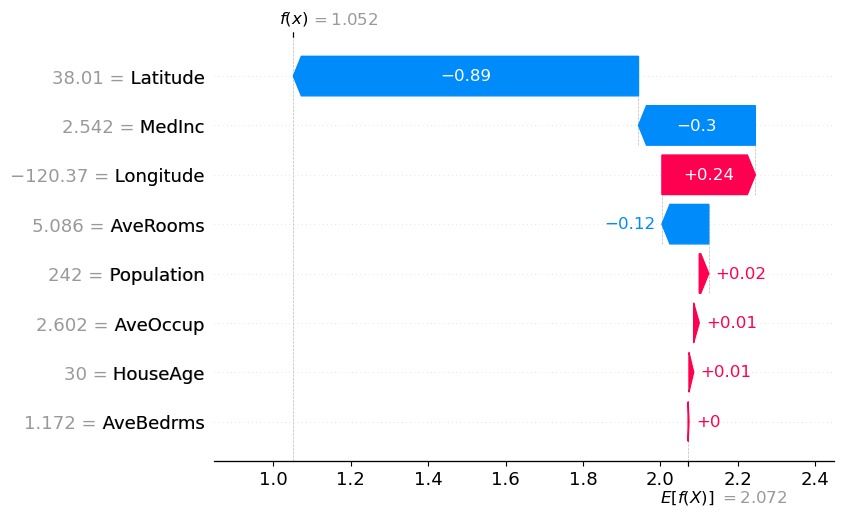

In [4]:
shap.plots.waterfall(shap_values[10])

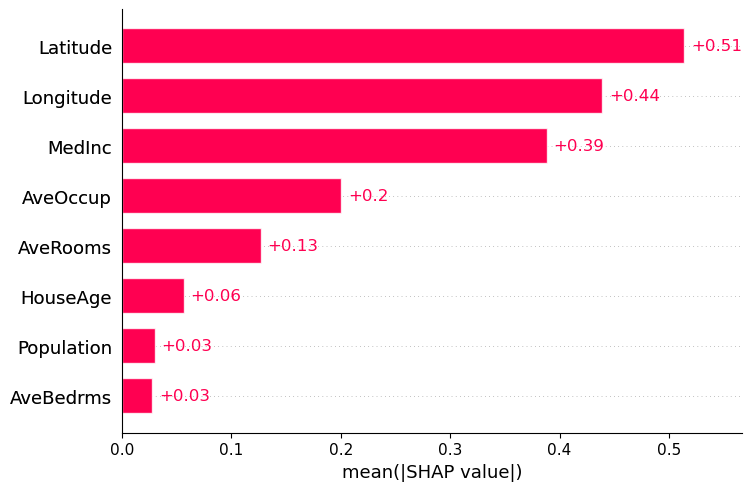

In [5]:
# global plot
#  the global importance of each feature is taken to be the mean absolute value
#  for that feature over all the given samples.
shap.plots.bar(shap_values)

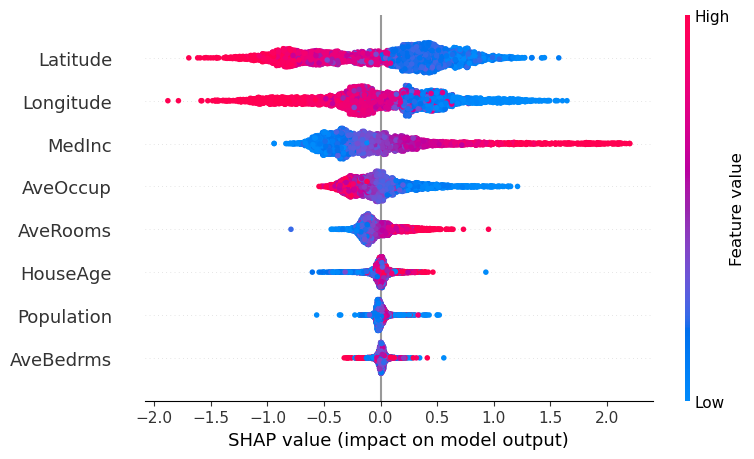

In [6]:
# Plot summary plot
shap.summary_plot(shap_values, X_test)

### MNIST example
[Code sourced from here](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html)

In [8]:
batch_size = 128
num_epochs = 5
device = torch.device("cpu")


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[
                1
            ]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )


train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "mnist_data",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "mnist_data", train=False, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    ),
    batch_size=batch_size,
    shuffle=True,
)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297333
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.115410
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.156022
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.903256
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.786111

Test set: Average loss: 0.0044, Accuracy: 8985/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.623740
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.569464
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.604121
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.577803
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.403486

Test set: Average loss: 0.0025, Accuracy: 9396/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.328623
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.442367
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.467029
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.277934
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.339348

Test set: Average loss: 0.0018, Accuracy: 9530/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.448520
Train Epoch: 4 [12800/60000 (21%)]	Lo

In [16]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, target = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [19]:
print("Label: ", target[100:103].numpy())
print("Prediction: ", torch.argmax(model(test_images), axis=1).numpy())

Label:  [2 2 5]
Prediction:  [2 2 5]


In [20]:
len(shap_values) # shap values for each of the 10 classes

10

In [21]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

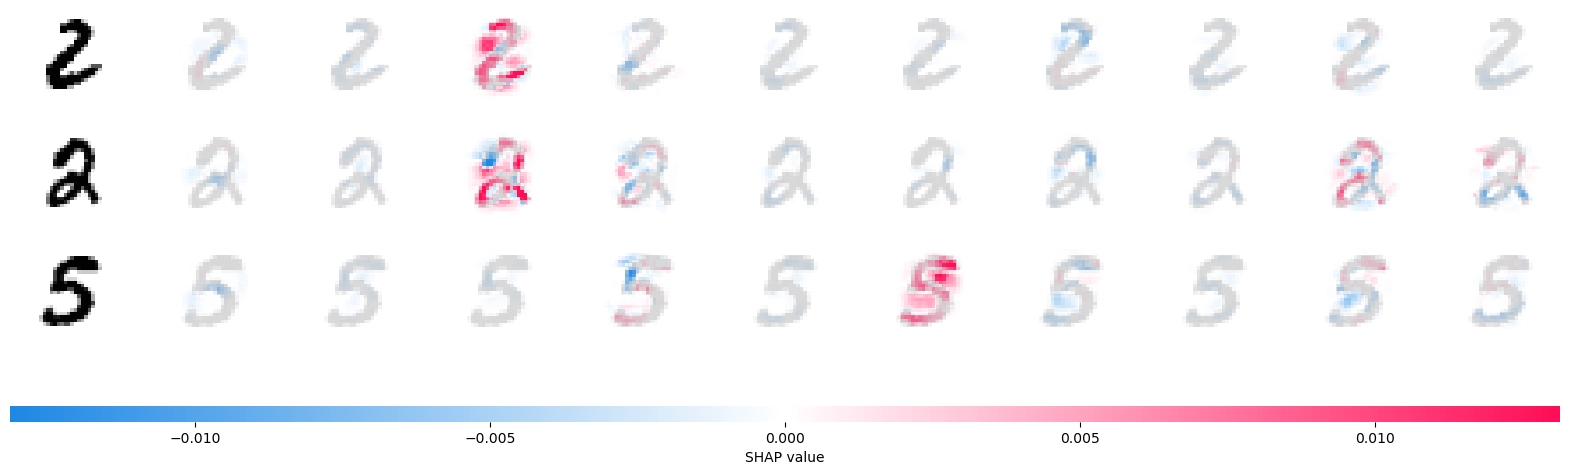

In [22]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy) # -is to invert image color

### Text Example 
[Code sourced from this link](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)

Explaining IMDB sentiment prediction (positive vs negative)


In [85]:
# load a BERT sentiment analysis model
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)

# define a prediction function
def f(x):

    tv = torch.tensor(
        [
            tokenizer.encode(v, padding="max_length", max_length=500, truncation=True)
            for v in x
        ]
    )
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:, 1])  # use one vs rest logit units
    return val

In [86]:
# load imdb data
imdb_train = datasets.load_dataset("imdb")["train"]

Found cached dataset imdb (/Users/gm845/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 95.98it/s]


In [89]:
# build an explainer using a token masker 
# (tokenizer tells Explainer what to do for missing input e.g. when calculating E[f(xS, X_{\S})])
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on IMDB reviews
shap_values = explainer(imdb_train[10:20], fixed_context=1, batch_size=2)

PartitionExplainer explainer: 11it [05:38, 33.82s/it]              


In [98]:
# plot a sentence's explanation
shap.plots.text(shap_values[5])

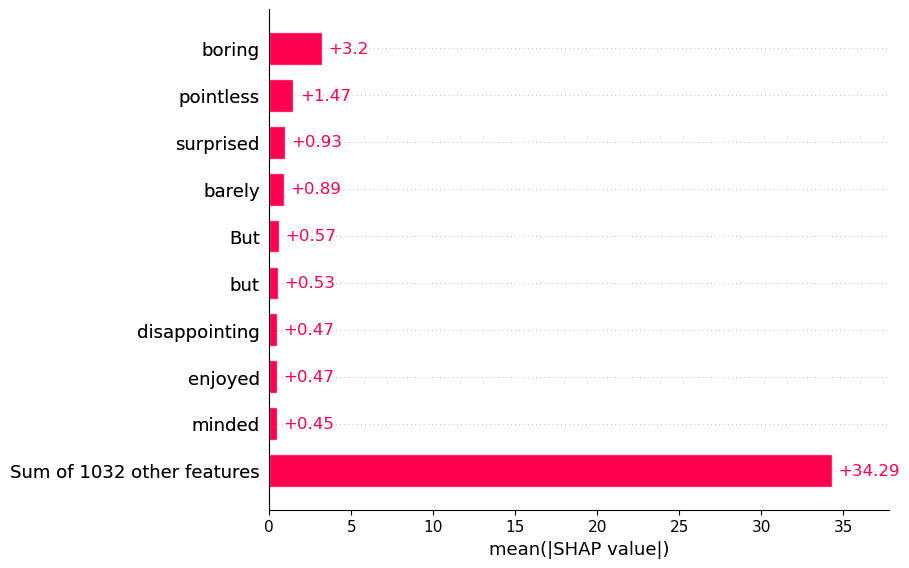

In [99]:
shap.plots.bar(shap_values.abs.mean(0))